In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
import os
from IPython.display import display
import os

Nous cherchons à prédire la positivité / négativité d'un tweet à l'aide de la **classification bayésienne naïve**.

# 0. Outils

Pas de standardisation ici

In [2]:
def conf_matrix(X, y, vectorizer, model, verbose=True):
    '''Trace la matrice de confusion du modèle souhaité'''
    X = vectorizer.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=1234)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    sc_accuracy = metrics.accuracy_score(y_pred, y_test)    
    sc_balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
    sc_f1 = metrics.f1_score(y_pred, y_test, pos_label="Positive")
    sc_recall = metrics.recall_score(y_pred, y_test, pos_label="Positive")
    sc_precision = metrics.precision_score(y_pred, y_test, pos_label="Positive")
    sc_roc_auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    probs = model.predict_proba(X_test)[:, 1]

    if verbose:
        metrics.plot_confusion_matrix(model, X_test, y_test)
        plt.show()

        print(f"Accuracy : {sc_accuracy}")
        print(f"Balanced accuracy : {sc_balanced_accuracy}")
    #     print(f"Recall : {sc_recall}")
    #     print(f"Precision : {sc_precision}")
    #     print(f"F1 : {sc_f1}")
        print(f"ROC AUC : {sc_roc_auc}")

    metrics_score = {'accuracy': sc_accuracy, 'balanced_accuracy': sc_balanced_accuracy, 'roc_auc': sc_roc_auc}

    if not verbose:
        return X_train, X_test, y_train, y_test, probs, metrics_score 

In [3]:
def comparaison(X, y, N, model, onlyTFID=False, show_graph=True, show_table=True):
    """
    Compraison des modèles par rapport à la courbe ROC
    N correspond au nombre de features
    """
    table = []
    
    if not onlyTFID:
        _, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N), model, verbose=False)
        fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
        if show_graph: plt.plot(fpr, tpr, ":", label=f"CountVectorizer {N}")
        table.append(metrics_score)

    _, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N), model, verbose=False)
    fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, ":", label=f"TfidfVectorizer {N}")
    table.append(metrics_score)
    
    if not onlyTFID:
        _, _, _, y_test, probs, metrics_score = conf_matrix(X, y, CountVectorizer(max_features = N, ngram_range=(2,2)), model, verbose=False)
        fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
        if show_graph: plt.plot(fpr, tpr, ":", label=f"CountVectorizer {N} ngram 2")
        table.append(metrics_score)

    _, _, _, y_test, probs, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features = N, ngram_range=(2,2)), model, verbose=False)
    fpr, tpr, _ = metrics.roc_curve(y_test, probs, pos_label="Positive")
    if show_graph: plt.plot(fpr, tpr, ":", label=f"TfidfVectorizer {N} ngram 2")
    table.append(metrics_score)
    
    if show_graph:
        plt.plot([0, 1], [0, 1], "r-")
        plt.plot([0, 0, 1], [0, 1, 1], 'b-')
        plt.legend()
        plt.show()
    
    index = [f"CountVectorizer {N}", f"TfidfVectorizer {N}", f"CountVectorizer {N} ngram 2", f"TfidfVectorizer {N} ngram 2"]
    if onlyTFID:
        index = [f"TfidfVectorizer {N}", f"TfidfVectorizer {N} ngram 2"]
    
    if show_table:
        display(pd.DataFrame(table, index=index))

In [4]:
def influence_features(X, y, max_features_list, model, onlyTFID=False):
    '''Evaluation de balanced_accuracy en fonction du nombre de features pour un modèle fixé'''
    table = []
    for max_features in max_features_list:
        if not onlyTFID:
            _, _, _, _, _, metrics_score = conf_matrix(X, y, CountVectorizer(max_features=max_features), model, verbose=False)
            metrics_score['features'] = max_features
            metrics_score['method'] = "CountVectorizer"
            table.append(metrics_score)

        _, _, _, _, _, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features=max_features), model, verbose=False)
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer"
        table.append(metrics_score)
        
        if not onlyTFID:
            _, _, _, _, _, metrics_score = conf_matrix(X, y, CountVectorizer(max_features=max_features, ngram_range=(2,2)), model, verbose=False)
            metrics_score['features'] = max_features
            metrics_score['method'] = "CountVectorizer ngram 2"
            table.append(metrics_score)

        _, _, _, _, _, metrics_score = conf_matrix(X, y, TfidfVectorizer(max_features=max_features, ngram_range=(2,2)), model, verbose=False)
        metrics_score['features'] = max_features
        metrics_score['method'] = "TfidfVectorizer ngram 2"
        table.append(metrics_score)

    df = pd.DataFrame(table)

    methods = list(set(df.method))
    scores = list(df.columns[:-2])
    fig, axes = plt.subplots(1, len(scores), figsize=(20, 6))
    for i_score in range(len(scores)):
        for j_method in range(len(methods)):
            df[df.method == methods[j_method]].plot(x='features', y=scores[i_score], label=methods[j_method], ax=axes[i_score])
        axes[i_score].set(xlabel='Nombre de features')
        axes[i_score].legend()
        axes[i_score].set_title(scores[i_score])
    plt.plot()
    return df

# 1. Chargement d'une base Sentiment140 préprocessée 

In [5]:
NB_DATA = 100000
STOP_WORDS = False
LEMMATIZATION = False
NEGATION = False
file = "train"
if STOP_WORDS:
    file += "_stop"
if LEMMATIZATION:
    file += "_lemm"
if NEGATION:
    file += "_neg"
df = pd.read_pickle(os.path.join("data", "sentiment140", file + ".bz2")).sample(NB_DATA, random_state=1234)

In [6]:
df.head(10)

,sentiment,id,date,query_string,user,text
599410,Negative,2220663113,Thu Jun 18 03:39:49 PDT 2009,NO_QUERY,gemgembam,open itunes will not open naooo the silence is...
549856,Negative,2202759103,Tue Jun 16 22:21:43 PDT 2009,NO_QUERY,twistofcolour,the sun is already gone for the day
1363048,Positive,2049441111,Fri Jun 05 16:53:10 PDT 2009,NO_QUERY,Niico1e,hiya this is my st tweet i am so tired though ...
558776,Negative,2204830292,Wed Jun 17 03:14:38 PDT 2009,NO_QUERY,MeriEsteban,i have the bac today at p m i do not know if i...
1582398,Positive,2190306594,Tue Jun 16 02:21:03 PDT 2009,NO_QUERY,MeghanMagnolia,as far as i remember you were not half bad ine...
1353343,Positive,2046706853,Fri Jun 05 12:34:26 PDT 2009,NO_QUERY,WahooPooh,as tempting as that is i am just waiting on my...
586354,Negative,2215937155,Wed Jun 17 18:49:10 PDT 2009,NO_QUERY,amandarie,cool how i have to be stuck at home i want to ...
860355,Positive,1676343245,Fri May 01 21:46:07 PDT 2009,NO_QUERY,MatchesMalone,oh and followfriday my writing partner because...
521668,Negative,2192486836,Tue Jun 16 07:06:35 PDT 2009,NO_QUERY,hockeyfan45214,you would think if i continue to block someone...
243888,Negative,1981647618,Sun May 31 09:35:54 PDT 2009,NO_QUERY,ilovemytroops,nevaeh buchanan missing friends of her mother ...


In [7]:
X = df.text.to_list()
y = df.sentiment.to_list()

# 2. Bernoulli Naive Bayes

## 2.1 Comparaison des méthodes de pré-processing

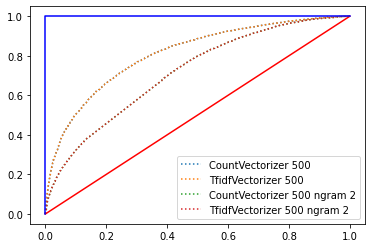

,accuracy,balanced_accuracy,roc_auc
CountVectorizer 500,0.73270,0.733570,0.810253
TfidfVectorizer 500,0.73270,0.733570,0.810253
CountVectorizer 500 ngram 2,0.65115,0.660163,0.714986
TfidfVectorizer 500 ngram 2,0.65115,0.660163,0.714986


Wall time: 12.6 s


In [8]:
%%time
comparaison(X, y, 500, BernoulliNB())

In [9]:
%%time
for stop_words in [False, True]:
#     for lemmatization in [False, True]:
    for lemmatization in [False]:
        for negation in [False, True]:
            file = "train"
            if stop_words:
                file += "_stop"
            if lemmatization:
                file += "_lemm"
            if  negation:
                file += "_neg"
            print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
            df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2")).sample(NB_DATA, random_state=1234)
            X = df.text.to_list()
            y = df.sentiment.to_list()
            comparaison(X, y, 500, BernoulliNB(), show_graph=False)

stop_words: False, lemmatization: False, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 500,0.73270,0.733570,0.810253
TfidfVectorizer 500,0.73270,0.733570,0.810253
CountVectorizer 500 ngram 2,0.65115,0.660163,0.714986
TfidfVectorizer 500 ngram 2,0.65115,0.660163,0.714986


stop_words: False, lemmatization: False, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 500,0.7279,0.728843,0.805885
TfidfVectorizer 500,0.7279,0.728843,0.805885
CountVectorizer 500 ngram 2,0.6264,0.636434,0.693166
TfidfVectorizer 500 ngram 2,0.6264,0.636434,0.693166


stop_words: True, lemmatization: False, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 500,0.72975,0.731065,0.807449
TfidfVectorizer 500,0.72975,0.731065,0.807449
CountVectorizer 500 ngram 2,0.60225,0.654658,0.641647
TfidfVectorizer 500 ngram 2,0.60225,0.654658,0.641647


stop_words: True, lemmatization: False, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 500,0.7184,0.720755,0.798458
TfidfVectorizer 500,0.7184,0.720755,0.798458
CountVectorizer 500 ngram 2,0.5544,0.618945,0.598638
TfidfVectorizer 500 ngram 2,0.5544,0.618945,0.598638


Wall time: 1min 20s


La combinaison optimale semble correspondre à `stop_words=False, lemmatization=False, negation=False` pour ce nombre de features.

## 2.2 Comparaison par rapport au nombre de features

Wall time: 59.9 s


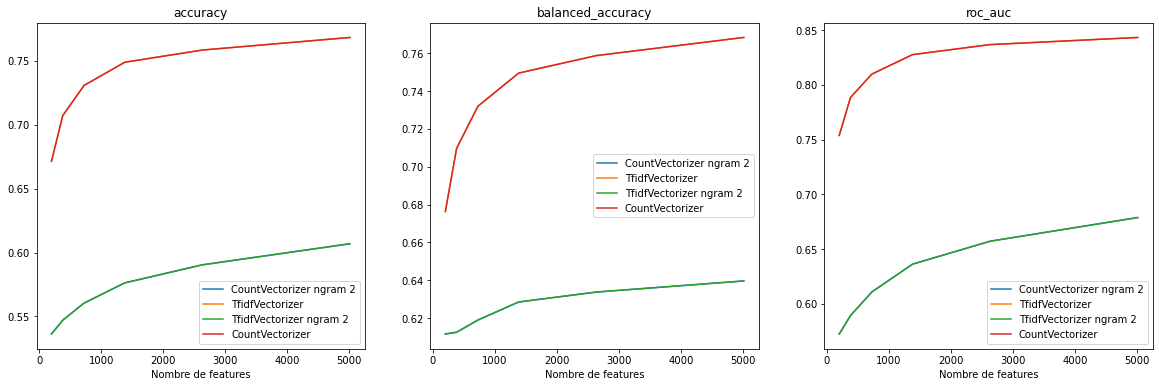

In [10]:
%%time
max_features_list = np.logspace(2.3, 3.7, 6, endpoint=True, dtype=int)
_ = influence_features(X, y, max_features_list, BernoulliNB())

# 3. Multinomial NB

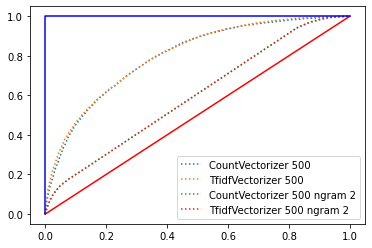

,accuracy,balanced_accuracy,roc_auc
CountVectorizer 500,0.71730,0.719054,0.796916
TfidfVectorizer 500,0.71665,0.719415,0.801048
CountVectorizer 500 ngram 2,0.55445,0.619230,0.598269
TfidfVectorizer 500 ngram 2,0.55405,0.621003,0.597811


Wall time: 10.4 s


In [11]:
%%time
comparaison(X, y, 500, MultinomialNB(alpha=1)) #par défaut alpha=1 : Laplace smoothing parameter

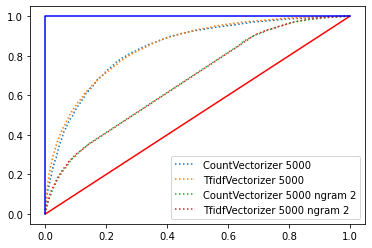

,accuracy,balanced_accuracy,roc_auc
CountVectorizer 5000,0.76735,0.767342,0.840192
TfidfVectorizer 5000,0.76335,0.763507,0.845655
CountVectorizer 5000 ngram 2,0.60655,0.639625,0.678196
TfidfVectorizer 5000 ngram 2,0.60510,0.641811,0.678005


Wall time: 10.8 s


In [12]:
%%time
comparaison(X, y, 5000, MultinomialNB(alpha=1)) #par défaut alpha=1 : Laplace smoothing parameter

A priori le TfIdfVectorizer (sans ngram) semble le plus approprié.

In [13]:
%%time
for stop_words in [False, True]:
#     for lemmatization in [False, True]:
    for lemmatization in [False]:
        for negation in [False, True]:
            file = "train"
            if stop_words:
                file += "_stop"
            if lemmatization:
                file += "_lemm"
            if  negation:
                file += "_neg"
            print(f"stop_words: {stop_words}, lemmatization: {lemmatization}, negation: {negation}")
            df = pd.read_pickle(os.path.join("data", "sentiment140", file+".bz2")).sample(NB_DATA, random_state=1234)
            X = df.text.to_list()
            y = df.sentiment.to_list()
            comparaison(X, y, 500, MultinomialNB(alpha=1), show_graph=False)

stop_words: False, lemmatization: False, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 500,0.73890,0.738908,0.811734
TfidfVectorizer 500,0.73705,0.737055,0.816858
CountVectorizer 500 ngram 2,0.65030,0.660677,0.711844
TfidfVectorizer 500 ngram 2,0.64915,0.658378,0.714424


stop_words: False, lemmatization: False, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 500,0.7323,0.732302,0.805787
TfidfVectorizer 500,0.7308,0.730854,0.813187
CountVectorizer 500 ngram 2,0.6250,0.634514,0.692893
TfidfVectorizer 500 ngram 2,0.6280,0.637498,0.695908


stop_words: True, lemmatization: False, negation: False


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 500,0.72610,0.726583,0.802730
TfidfVectorizer 500,0.72240,0.723598,0.803520
CountVectorizer 500 ngram 2,0.59950,0.661967,0.636240
TfidfVectorizer 500 ngram 2,0.59925,0.662761,0.636228


stop_words: True, lemmatization: False, negation: True


,accuracy,balanced_accuracy,roc_auc
CountVectorizer 500,0.71730,0.719054,0.796916
TfidfVectorizer 500,0.71665,0.719415,0.801048
CountVectorizer 500 ngram 2,0.55445,0.619230,0.598269
TfidfVectorizer 500 ngram 2,0.55405,0.621003,0.597811


Wall time: 1min 26s


La combinaison optimale semble correspondre à `stop_words=False, lemmatization=False, negation=False` pour ce nombre de features.

Wall time: 59 s


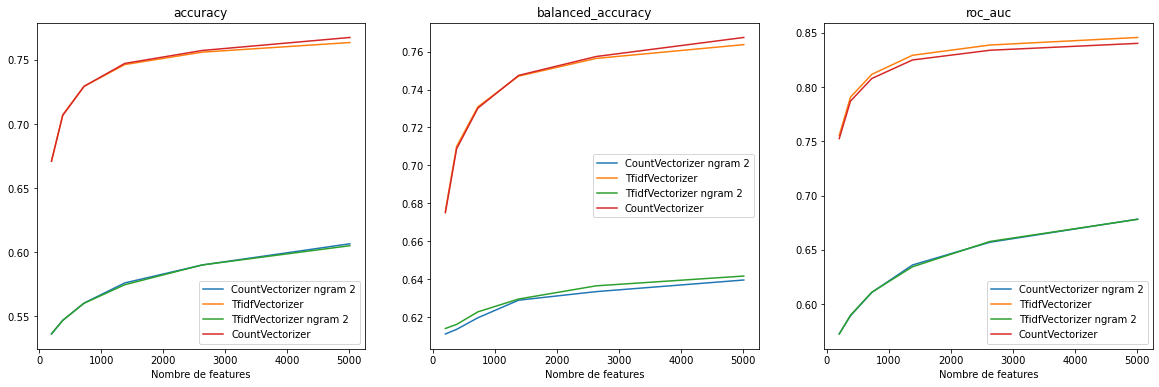

In [14]:
%%time
_ = influence_features(X, y, max_features_list, MultinomialNB(alpha=1))

## 3.1. Grid Search

In [15]:
%%time
#CountVectorizer
text_clf = Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB())])

parameters = {'vect__max_features' : [None, 5000, 10000, 20000],
          'clf__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1]
}

grid_clf = GridSearchCV(text_clf, parameters, scoring = 'balanced_accuracy', cv=5)
_ = grid_clf.fit(X, y)

print(grid_clf.best_params_)

{'clf__alpha': 1, 'vect__max_features': None}
Wall time: 3min 48s


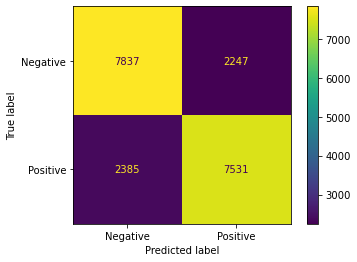

Accuracy : 0.7684
Balanced accuracy : 0.7684390575051008
ROC AUC : 0.8401639569688036


In [16]:
conf_matrix(X, y, CountVectorizer(max_features=None), MultinomialNB(alpha=1))

In [17]:
%%time
#Tfidfvectorizer
text_clf = Pipeline([('idf', TfidfVectorizer()), ('clf', MultinomialNB())])

parameters = {'idf__max_features' : [None, 5000, 10000, 20000],
          'clf__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1]
}

grid_clf = GridSearchCV(text_clf, parameters, scoring = 'balanced_accuracy', cv=5)
_ = grid_clf.fit(X, y)

print(grid_clf.best_params_)

{'clf__alpha': 1, 'idf__max_features': 10000}
Wall time: 3min 42s


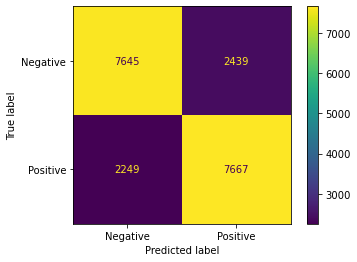

Accuracy : 0.7656
Balanced accuracy : 0.7656743711723449
ROC AUC : 0.8464307241518961


In [18]:
conf_matrix(X, y, TfidfVectorizer(max_features=10000), MultinomialNB(alpha=1))